# SYDE 522 Project Code
Chang Li, Maathusan Rajendram, Anastasia Santasheva, Evan Yeung

## Import Packages


In [1]:
# standard useful packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# validation & normalization methods
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut

# accuracy, MSE, log loss & timer methods
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from time import time

# dim reduction & classification methods 
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, BaggingClassifier

# make matplotlib to show plots inline
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Set Configuration
* Select options for method validation
* Set parameters

In [83]:
# 1. set dataset
ENABLE_POR_DATA = True     # set Portugese course dataset
ENABLE_MAT_DATA = False    # set Math course dataset

# 2. set input setup
ENABLE_INPUT_SETUP_B = True   # adds the delta of G1 and G2 as a new col (GDelta)

# 3. set supervised approach for G3
ENABLE_BINARY_TARGET = False       # sets G3 to binary
ENABLE_5LEVEL_TARGET = False        # set G3 to five-level scale
ENABLE_REGRESSION_TARGET = True   # set G3 to current state for regression

# 4. set dimensionaltiy reduction method - set both to false for none
ENABLE_PCN = True
ENABLE_LDA = False

# 5. set validation type
ENABLE_KFOLD = True
ENABLE_LOO = False

# 6. set final test
ENABLE_TEST = False

## Load  Dataset
* Select a data set (Portugese course or Math course)

In [84]:
# import data from csv
if (ENABLE_POR_DATA):
    dataframe = pd.read_csv('student-por-train.csv', usecols = range(0,33)) 
    dataframe_test = pd.read_csv('student-por-test.csv', usecols = range(0,33)) 
elif (ENABLE_MAT_DATA): 
    dataframe = pd.read_csv('student-mat-train.csv', usecols = range(0,33))
    dataframe_test = pd.read_csv('student-mat-test.csv', usecols = range(0,33))

# shuffle dataset
dataframe = dataframe.sample(frac=1)

# find col length
num_cols = dataframe.shape[1]

## Preprocessing

* Convert nominal attributes with Integer + One-Hot Encoding
* Selects supervised approache for G3
* NOTE: if we want we can also split further into A,B,C (A= all cols, B=same as A without G2, C=same as B without G1)
    * But leaving this out for now since we know A gives best accuracy

In [85]:
# helper functions for preprocessing
def convertToBinary(df, num_cols):
    df.loc[(df.G3 < 10), 'G3'] = 0
    df.loc[(df.G3 >= 10), 'G3'] = 1
    
    G3 = df['G3'].values
    return G3

def convertToFiveLevel(df, num_cols):
    df.loc[(df.G3 <= 9), 'G3'] = 0
    df.loc[(df.G3 > 9) & (df.G3 <= 11), 'G3'] = 1
    df.loc[(df.G3 > 11) & (df.G3 <= 13), 'G3'] = 2
    df.loc[(df.G3 > 13) & (df.G3 <= 16), 'G3'] = 3
    df.loc[(df.G3 > 16), 'G3'] = 4
    
    G3 = df['G3'].values
    return G3   

def convertToInputSetupB(df, num_cols):
    df.insert(num_cols-1, 'GDelta', df.G2 - df.G1, allow_duplicates=True)
    
    return df

def oneHotEncode(df):
    df = df.drop(labels='G3', axis=1)
    cols_to_transform = [
                        'school',
                        'sex',
                        'address',
                        'famsize',
                        'Pstatus',
                        'Mjob',                        
                        'Fjob',
                        'reason',
                        'guardian',
                        'famsup',
                        'schoolsup',
                        'paid',
                        'activities',
                        'nursery',                        
                        'higher',
                        'internet',
                        'romantic',
                        ]
    hot_encoded_df = pd.get_dummies(df, columns = cols_to_transform)
    
    attributes = hot_encoded_df.values
    return attributes

def normalizeData(train_data, val_data):
    scaler = StandardScaler().fit(train_data)
    train_data = scaler.transform(train_data)
    val_data = scaler.transform(val_data)
    
    return train_data, val_data

# labels of Y
labels = []

# switch to input setup B
if (ENABLE_INPUT_SETUP_B): 
    dataframe = convertToInputSetupB(dataframe, num_cols)
    dataframe_test = convertToInputSetupB(dataframe_test, num_cols)

# split one-hot encoded attributes (X) and G3 (Y)
X = oneHotEncode(dataframe)
X_tst = oneHotEncode(dataframe_test)

# selects supervised approach for G3
if (ENABLE_BINARY_TARGET):
    Y = convertToBinary(dataframe, num_cols).astype('int')
    Y_tst = convertToBinary(dataframe_test, num_cols).astype('int')
    labels = [0, 1]
elif (ENABLE_5LEVEL_TARGET):
    Y = convertToFiveLevel(dataframe, num_cols).astype('int')
    Y_tst = convertToFiveLevel(dataframe_test, num_cols).astype('int')
    labels = [0, 1, 2, 3, 4]
elif (ENABLE_REGRESSION_TARGET):
    Y = dataframe['G3'].values.astype('int')
    Y_tst = dataframe_test['G3'].values.astype('int')
    

In [86]:
# Y
X.shape, Y.shape, X_tst.shape, Y_tst.shape

((519, 59), (519,), (130, 59), (130,))

Text(0.5,1,'Language Dataset')

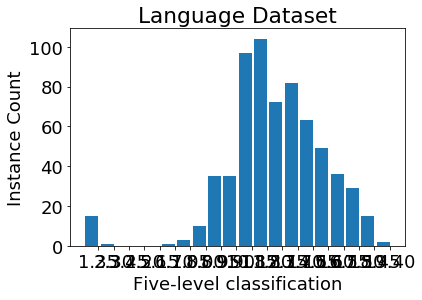

In [87]:

def bins_labels(bins, **kwargs):
    bin_w = (max(bins) - min(bins)) / (len(bins) - 1)
    plt.xticks(np.arange(min(bins)+bin_w/2, max(bins), bin_w), bins, **kwargs)
    plt.xlim(bins[0], bins[-1])
     
# Combine Y and plot as histogram
# 6 graphs lang - (Binary, 5Level, 20 level)
temp_y = np.concatenate([Y, Y_tst])

unique, counts = np.unique(temp_y, return_counts=True)
table = dict(zip(unique, counts))

# plt.hist(temp_y)

# plt.xticks(np.arange(5), ('A', 'B', 'C', 'D', 'F'))
# plt.xlabel('Five-level classification')
# plt.ylabel('Instance Count')
# plt.title('Language Dataset')

# plt.winter()

# plt.xlabel('Five-level classification')
# plt.ylabel('Instance Count')
# plt.title('Language Dataset')
# # plt.axis([40, 160, 0, 0.03])
# # plt.grid(True)
# bins_labels(bins, fontsize=20)

# plt.show()

bins = [0,1,2,3,4,5]
his = np.histogram(temp_y, bins=20)
# bins_labels(bins, fontsize=20)
fig, ax = plt.subplots()
offset = .4
plt.bar(his[1][1:],his[0])
ax.set_xticks(his[1][1:] + offset)
# ax.set_xticklabels( ('A', 'B', 'C', 'D', 'F') )
plt.xlabel('Five-level classification')
plt.ylabel('Instance Count')
plt.title('Language Dataset')

    
# mu, sigma = 100, 15
# x = mu + sigma*np.random.randn(10000)

# the histogram of the data
# n, bins, patches = plt.hist(x, 50, normed=1, facecolor='green', alpha=0.75)


# f, axarr = plt.subplots(2, sharex=False)
# f.suptitle('Error and Log Loss', y = 0.92)
# f.set_size_inches(10, 10)

# # subplot 1: error plot
# axarr[0].set_ylabel('Error')
# axarr[0].plot(hyperparams, results[0], color='r', label='train')
# axarr[0].plot(hyperparams, results[1], color='b', label='validation')
# axarr[0].set_xticks(hyperparams)
# axarr[0].legend()

# # subplot 2: log loss plot
# axarr[1].set_ylabel('Log Loss')
# axarr[1].plot(hyperparams, results[2], color='g', label='log loss')
# axarr[1].set_xticks(hyperparams)
# axarr[1].set_xlabel('Parameter')
# plt.show()
    




## Dimensionality Reduction
* PCA & LDA reduction methods

In [88]:
def pcaReduction(train_data, val_data, n_comp):
    pca = PCA(n_components=n_comp)
    train_data = pca.fit_transform(train_data)
    val_data = pca.transform(val_data)
    
    return train_data, val_data

def ldaReduction(train_data, train_target, val_data, n_comp):
    lda = LinearDiscriminantAnalysis(n_components=n_comp)
    train_data = lda.fit_transform(train_data, train_target)
    val_data = lda.transform(val_data)
    
    return train_data, val_data


## Validation Methods
* k-Fold cross validation & Leave-one-out validation
* data gets normalized here

In [89]:
# method to calculate accuracy (PCC) & RMSE
def calcMetric(actual, predicted):
    if(ENABLE_REGRESSION_TARGET): return (mean_squared_error(actual, predicted))**(0.5) # calculates RMSE
    else: return accuracy_score(actual, predicted, normalize = True) # calculates PCC

def kFoldValidation(n_comp, penalty, n_splits=10):
    kFold = KFold(n_splits=n_splits)
    
    # run on validation data
    val_results = []
    train_results = []
    log_loss_results = []
    time_log = []
    
    for train_index, val_index in kFold.split(X):
        #start timer, return avg time below
        start = time()
        
        X_train, X_val = X[train_index], X[val_index]
        Y_train, Y_val = Y[train_index], Y[val_index]
        
        # normalize data
        X_train, X_val = normalizeData(X_train, X_val)
        
        # reduce dimensionality
        if (ENABLE_PCN): X_train, X_val = pcaReduction(X_train, X_val, n_comp)
        elif (ENABLE_LDA): X_train, X_val = ldaReduction(X_train, Y_train, X_val, n_comp)
        
        # build classifier for each set
        clf = buildClf(X_train, Y_train, penalty)
        
        predicted = clf.predict(X_val)
        val_accuracy = calcMetric(Y_val, predicted)
        predicted = clf.predict(X_train)
        train_accuracy = calcMetric(Y_train, predicted)
        
        # log loss calculation - for classification only
        if(not ENABLE_REGRESSION_TARGET): log_loss_results.append(log_loss(Y_val, clf.predict_proba(X_val), labels=labels))
        
        val_results.append(val_accuracy)
        train_results.append(train_accuracy)
        time_log.append(time()-start)
        
    return np.mean(train_results, axis = 0), np.mean(val_results, axis = 0), np.mean(log_loss_results, axis = 0), np.mean(time_log, axis = 0)

def looValidation(n_comp, penalty):
    loo = LeaveOneOut()
    
    # run on validation data
    val_results = []
    train_results = []
    Y_test_prob = []
    log_loss_value = 0
    time_log = []
    
    for train_index, val_index in loo.split(X):
        #start timer, return avg time below
        start = time()
        
        X_train, X_val = X[train_index], X[val_index]
        Y_train, Y_val = Y[train_index], Y[val_index]
        
        # normalize data
        X_train, X_val = normalizeData(X_train, X_val)
        
        # reduce dimensionality
        if (ENABLE_PCN): X_train, X_val = pcaReduction(X_train, X_val, n_comp)
        elif (ENABLE_LDA): X_train, X_val = ldaReduction(X_train, Y_train, X_val, n_comp)
        
        # build classifier for each set
        clf = buildClf(X_train, Y_train, penalty)
        
        predicted = clf.predict(X_val)
        val_accuracy = calcMetric(Y_val, predicted)
        predicted = clf.predict(X_train)
        train_accuracy = calcMetric(Y_train, predicted)
        
        # save probability for log loss calculation
        if(not ENABLE_REGRESSION_TARGET): Y_test_prob.append(clf.predict_proba(X_val)[0])
            
        test_results.append(test_accuracy)
        val_results.append(val_accuracy)
        train_results.append(train_accuracy)
        time_log.append(time()-start)
    
    # log loss calculation - for classification only
    if(not ENABLE_REGRESSION_TARGET): log_loss_value = log_loss(Y, Y_test_prob, labels=labels)

    return np.mean(train_results, axis = 0), np.mean(val_results, axis = 0), log_loss_value, np.mean(time_log, axis = 0)

## Classifier Selection
* Select classifer to validate

In [90]:
def getVotingClassifier(penalty):
#     clf1 = SVC(C=10, probability=True, kernel='linear')
#     clf1 = SVR(C=penalty, kernel='linear')
#     clf2 = MLPClassifier(solver = 'lbfgs', hidden_layer_sizes=penalty)
    clf2 = DecisionTreeClassifier(max_depth = 3)
    clf3 = RandomForestClassifier(max_depth = 18, n_estimators = 250)
    
    return VotingClassifier(estimators=[('dt', clf2), ('rf', clf3)], voting='soft')  #, weights = [1,2,3]
#     return VotingClassifier(estimators=[('svm', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard') #, weights = [1,2,3]

# method to build classifier
def buildClf(train_data, train_target, penalty):
    
    if(ENABLE_REGRESSION_TARGET):
        model = SVR(C=penalty, kernel='linear')
#         model = AdaBoostClassifier(base_estimator=SVR(C=penalty, kernel='linear'))
#         model = BaggingClassifier(base_estimator=SVR(C=penalty, kernel='linear'))
#         model = getVotingClassifier(penalty)
    else:
#         model = SVC(C=penalty, probability=True, kernel='linear')
#         model = AdaBoostClassifier(base_estimator=SVC(C=penalty, probability=True, kernel='linear'))
#         model = BaggingClassifier(base_estimator=SVC(C=penalty, probability=True, kernel='linear'))
        model = getVotingClassifier(penalty)
#         model = AdaBoostClassifier(base_estimator=getVotingClassifier(penalty))
#         model = BaggingClassifier(base_estimator=getVotingClassifier(penalty))
    
#         model = GaussianNB()
#         model = MLPClassifier(solver = 'lbfgs', hidden_layer_sizes=penalty)
#         model = DecisionTreeClassifier(max_depth = None, max_features = penalty, criterion = "entropy")
#         model = RandomForestClassifier(n_estimators = penalty, max_features=450, criterion = "entropy")
#         model = KNeighborsClassifier(n_neighbors=penalty, p=1)
#         model = BaggingClassifier(DecisionTreeClassifier(max_features = penalty, criterion = "entropy"), max_samples=0.5, max_features=6)

    model.fit(train_data, train_target)
    return model

## Final Test Method
* Run best classifier on unseen test set

In [91]:
# get accuracy/RMSE, logloss and time 
def runTestSet(X_train, Y_train, X_test, Y_test, n_comp, penalty):
    
    start = time()
    test_log_loss = 0
    
    # normalize data
    X_train, X_test = normalizeData(X_train, X_test)

    # reduce dimensionality
    if (ENABLE_PCN): X_train, X_test = pcaReduction(X_train, X_test, n_comp)
    elif (ENABLE_LDA): X_train, X_test = ldaReduction(X_train, Y_train, X_test, n_comp)

    # build classifier, predict and get accuracy
    clf = buildClf(X_train, Y_train, penalty)
    predicted = clf.predict(X_test)
    test_accuracy = calcMetric(Y_test, predicted)
    
    # log loss calculation - for classification only
    if(not ENABLE_REGRESSION_TARGET): test_log_loss = log_loss(Y_test, clf.predict_proba(X_test))
        
    # execution time calculation
    test_time = time()-start
    
    return test_accuracy, test_log_loss, test_time

## Obtain Accuracy, Log Loss & Error
* Adjust array of penalty parameters
* Graphs error and log loss - for classification only

-----C=5-----
Time: 0.021698307991027833 seconds
-----Train-----
Accuracy/RMSE: 2.3327239387401706
-----Validation-----
Accuracy/RMSE: 2.3744024815112947
Log Loss: nan

-----C=10-----
Time: 0.03670415878295898 seconds
-----Train-----
Accuracy/RMSE: 2.143156158730947
-----Validation-----
Accuracy/RMSE: 2.1905655234018604
Log Loss: nan

-----C=30-----
Time: 0.11024777889251709 seconds
-----Train-----
Accuracy/RMSE: 1.411642617840526
-----Validation-----
Accuracy/RMSE: 1.4723835288999394
Log Loss: nan

-----C=45-----
Time: 0.1804802417755127 seconds
-----Train-----
Accuracy/RMSE: 1.289238876188332
-----Validation-----
Accuracy/RMSE: 1.3333236193550193
Log Loss: nan

-----C=50-----
Time: 0.17775497436523438 seconds
-----Train-----
Accuracy/RMSE: 1.289238876188332
-----Validation-----
Accuracy/RMSE: 1.3333236193550193
Log Loss: nan



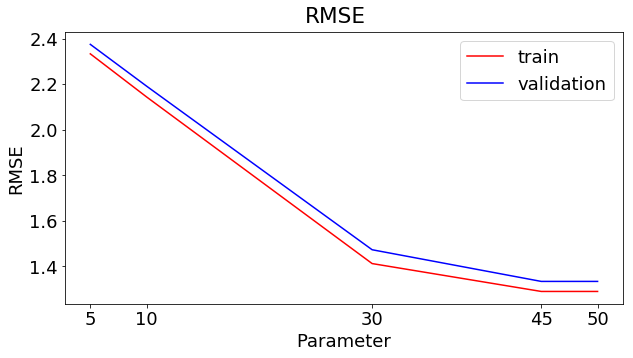

In [92]:
# input reduced dimension - this can be ignored if none selected
n_comp = 1

# input parameter iterations - can tune other params in classifer selection method above
if(not ENABLE_TEST):
    # hyperparams = [None]
    hyperparams = [5, 10, 30, 45, 50]
else: hyperparams = [10] # input best parameter for test

# results array format: [[train], [validation], [log loss]]
results = [[],[],[]]

# calculate train error, test error, log loss & time for specific param
for penalty in hyperparams:
    
    if (ENABLE_KFOLD): train_res, val_res, log_loss_val, time_val = kFoldValidation(penalty, n_comp, 10)
    elif (ENABLE_LOO): train_res, val_res, log_loss_val, time_val = looValidation(n_comp, penalty)
    
    # save error, RMSE, log loss for each penalty for graph
    if (not ENABLE_REGRESSION_TARGET):
        results[0].append(1-train_res)
        results[1].append(1-val_res)
        results[2].append(log_loss_val)
    elif (ENABLE_REGRESSION_TARGET):
        results[0].append(train_res)
        results[1].append(val_res)

    print ("-----C={}-----".format(penalty))
    print ("Time: {} seconds".format(time_val))
    print ("-----Train-----")
    print ("Accuracy/RMSE: {}".format(train_res))
    print ("-----Validation-----")
    print ("Accuracy/RMSE: {}".format(val_res))
    print ("Log Loss: {}\n".format(log_loss_val))
    
# run best model on unseen test set
if(ENABLE_TEST):
    test_accuracy, test_log_loss, test_time = runTestSet(X, Y, X_tst, Y_tst, n_comp, hyperparams[0])

    print ("-----Test-----")
    print ("Accuracy/RMSE: {}".format(test_accuracy))
    print ("Log Loss: {}".format(test_log_loss))
    print ("Time: {} seconds".format(test_time))

# create error and log loss graph for penalty iterations - classification only
if(not ENABLE_REGRESSION_TARGET and len(hyperparams) > 1):
    f, axarr = plt.subplots(2, sharex=False)
    f.suptitle('Error and Log Loss', y = 0.92)
    f.set_size_inches(10, 10)

    # subplot 1: error plot
    axarr[0].set_ylabel('Error')
    axarr[0].plot(hyperparams, results[0], color='r', label='train')
    axarr[0].plot(hyperparams, results[1], color='b', label='validation')
    axarr[0].set_xticks(hyperparams)
    axarr[0].legend()

    # subplot 2: log loss plot
    axarr[1].set_ylabel('Log Loss')
    axarr[1].plot(hyperparams, results[2], color='g', label='log loss')
    axarr[1].set_xticks(hyperparams)
    axarr[1].set_xlabel('Parameter')
    plt.show()
    
# create RMSE graph for penalty iterations - regression only
if(ENABLE_REGRESSION_TARGET and len(hyperparams) > 1):
    f, axarr = plt.subplots(sharex=False)
    f.suptitle('RMSE', y = 0.95)
    f.set_size_inches(10, 5)

    # subplot 1: RMSE plot
    axarr.set_ylabel('RMSE')
    axarr.plot(hyperparams, results[0], color='r', label='train')
    axarr.plot(hyperparams, results[1], color='b', label='validation')
    axarr.set_xticks(hyperparams)
    axarr.set_xlabel('Parameter')
    axarr.legend()
    font = {'weight' : 'normal', 'size'   : 18}
    plt.rc('font', **font)
    plt.show()


## Ensemble Methods